TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as  dnsnvbn!tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal

In [5]:
import math

In [35]:
import pickle

In [33]:
import sys, os

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
'''def calc_U(shape, h, h_max): #dim_i, dim_j):
    dim_i, dim_j = calc_dim(shape, h, h_max)
    U = []
    for i in range(dim_i):
        for j in range(dim_j):
            U += [(i, j)]
    return U'''
from waveimage import calc_U

In [9]:
def mnist_reshape_32_buf(x):
    assert x.shape == (28 * 28,)
    image = x.reshape(28,28)
    image = np.append(np.zeros((2,28)), image, axis = 0)
    image = np.append(image, np.zeros((2,28)), axis = 0)
    image = np.append(np.zeros((32,2)), image, axis = 1)
    image = np.append(image, np.zeros((32,2)), axis = 1)
    return image


## Creation de la base d'apprentissage

In [10]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

# Construction du réseau

In [11]:
class Obj:
    pass

In [12]:
params = Obj()
params.batch_size = 100

In [13]:
batch = mnist.train.next_batch(params.batch_size)
wave_tensor = wave_tensor_data(batch[0])

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [14]:
DEPTH_WAV = 3

DIM_5 = 16
WIDTH = 2

DEPTH_4 = 64
DIM_4 = DIM_5 / WIDTH # 8

DEPTH_3 = 64
DIM_3 = DIM_4 / WIDTH # 4

DEPTH_2 = 64
DIM_2 = DIM_3 / WIDTH # 2

DEPTH_1 = 64
DIM_1 = DIM_2 / WIDTH # 1

DIM_HIDDEN = 512

NB_LABEL = 10

STD = 1.

In [15]:
nb_param_54 = (DEPTH_WAV * WIDTH * WIDTH) * DEPTH_4
nb_param_43 = (DEPTH_4 * WIDTH * WIDTH) * DEPTH_3
nb_param_32 = (DEPTH_3 * WIDTH * WIDTH) * DEPTH_2
nb_param_21 = (DEPTH_2 * WIDTH * WIDTH) * DEPTH_1
nb_param_1h = (DEPTH_1 + DEPTH_WAV + 1) * DIM_HIDDEN
nb_param_hr = DIM_HIDDEN * NB_LABEL
print nb_param_54, nb_param_43, nb_param_32, nb_param_21, nb_param_1h, nb_param_hr

768 16384 16384 16384 34816 5120


In [16]:
def weight_variable(shape, stddev = 0.1, name = "dummy"):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    initial = tf.random_normal(shape, stddev = stddev)
    #initial = tf.zeros(shape)
    return tf.Variable(initial, name = name)

### placeholders

In [17]:
x_5 = tf.placeholder(tf.float32, shape=[None, DIM_5, DIM_5, DEPTH_WAV])
x_4 = tf.placeholder(tf.float32, shape=[None, DIM_4, DIM_4, DEPTH_WAV])
x_3 = tf.placeholder(tf.float32, shape=[None, DIM_3, DIM_3, DEPTH_WAV])
x_2 = tf.placeholder(tf.float32, shape=[None, DIM_2, DIM_2, DEPTH_WAV])
x_1 = tf.placeholder(tf.float32, shape=[None, DIM_1, DIM_1, DEPTH_WAV])
x_0 = tf.placeholder(tf.float32, shape=[None, 1, 1, 1])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
batch_phase = tf.placeholder(tf.bool, name='bn_phase')

In [18]:
l1_loss = tf.constant(0.0)

### Layers

#### 5 --> 4

In [19]:
# Paramètres
W_conv_54 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4], \
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                            name = "W_conv_54")
# Graph construction
h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_4') 
h_pool_4 = tf.nn.max_pool(h_conv_4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_4')
h_pool_4_bn = tf.contrib.layers.batch_norm(h_pool_4, center=True, scale=True, is_training=batch_phase, scope='h_pool_4', updates_collections=None)
z_conv_4 = tf.nn.relu(h_pool_4_bn)

#h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_4') 
#h_conv_4_bn = tf.contrib.layers.batch_norm(h_conv_4, center=True, scale=True, is_training=batch_phase, scope='h_conv_4', updates_collections=None)
#z_conv_4 = tf.nn.relu(h_conv_4_bn)

cat_conv_4 = tf.concat((z_conv_4, x_4), axis = 3)


#### 4 --> 3

In [20]:
# Paramètres
W_conv_43 = weight_variable([WIDTH, WIDTH, DEPTH_4 + DEPTH_WAV, DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_4 + DEPTH_WAV)), \
                            name = "W_conv_43")

h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_3') 
h_pool_3 = tf.nn.max_pool(h_conv_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_3')
h_pool_3_bn = tf.contrib.layers.batch_norm(h_pool_3, center=True, scale=True, is_training=batch_phase, scope='h_pool_3', updates_collections=None)
z_conv_3 = tf.nn.relu(h_pool_3_bn)

# Graph construction
#h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_3') 
#h_conv_3_bn = tf.contrib.layers.batch_norm(h_conv_3, center=True, scale=True, is_training=batch_phase, scope='h_conv_3', updates_collections=None)
#z_conv_3 = tf.nn.relu(h_conv_3_bn)

cat_conv_3 = tf.concat((z_conv_3, x_3), axis = 3)


#### 3 --> 2

In [21]:
# Paramètres
W_conv_32 = weight_variable([WIDTH, WIDTH, DEPTH_3 + DEPTH_WAV, DEPTH_2],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_3 + DEPTH_WAV)), \
                            name = "W_conv_32")

# Graph construction
h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_2') 
h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2')
h_pool_2_bn = tf.contrib.layers.batch_norm(h_pool_2, center=True, scale=True, is_training=batch_phase, scope='h_pool_2', updates_collections=None)
z_conv_2 = tf.nn.relu(h_pool_2_bn)

#h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_2') 
#h_conv_2_bn = tf.contrib.layers.batch_norm(h_conv_2, center=True, scale=True, is_training=batch_phase, scope='h_conv_2', updates_collections=None)
#z_conv_2 = tf.nn.relu(h_conv_2_bn)

cat_conv_2 = tf.concat((z_conv_2, x_2), axis = 3)


#### 2 --> 1

In [22]:
# Paramètres
W_conv_21 = weight_variable([WIDTH, WIDTH, DEPTH_2 + DEPTH_WAV, DEPTH_1],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_2 + DEPTH_WAV)), \
                            name = "W_conv_21")

h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_1') 
h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1')
h_pool_1_bn = tf.contrib.layers.batch_norm(h_pool_1, center=True, scale=True, is_training=batch_phase, scope='h_pool_1', updates_collections=None)
z_conv_1 = tf.nn.relu(h_pool_1_bn)

# Graph construction
#h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_1') 
#h_conv_1_bn = tf.contrib.layers.batch_norm(h_conv_1, center=True, scale=True, is_training=batch_phase, scope='h_conv_1', updates_collections=None)
#z_conv_1 = tf.nn.relu(h_conv_1_bn)

cat_conv_1 = tf.concat((z_conv_1, x_1, x_0), axis = 3)
z_flat1 = tf.reshape(cat_conv_1, [-1, DEPTH_1 + DEPTH_WAV + 1])

#### hidden FC layer

In [23]:
W_hidden = weight_variable([DEPTH_1 + DEPTH_WAV + 1, DIM_HIDDEN], stddev = STD / (DEPTH_1 + DEPTH_WAV + 1), name = "W_hidden")
h_hidden = tf.matmul(z_flat1, W_hidden)
z_hidden = tf.nn.relu(h_hidden)
z_hidden_drop = tf.nn.dropout(z_hidden, keep_prob)

#### readout layer

In [24]:
W_readout = weight_variable([DIM_HIDDEN, NB_LABEL], stddev = STD / DIM_HIDDEN, name = "W_readout")
y_hat_logit = tf.matmul(z_hidden_drop, W_readout)

### Loss graph¶

In [25]:
classif_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat_logit))

l1_regularizer = tf.contrib.layers.l1_regularizer(
   scale=0.005, scope=None
)
weights = tf.trainable_variables() # all vars of your graph
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

regularized_loss = classif_loss #+ regularization_penalty # this loss needs to be min

### Train graph¶

In [26]:
train = tf.train.AdamOptimizer(1e-3).minimize(regularized_loss)

### Evaluation graph

In [27]:
correct_prediction = tf.equal(tf.argmax(y_hat_logit, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training session

In [28]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [29]:
mem = Obj()
mem.num_epoch = []
mem.classif_eval = []


In [30]:
params.n_epochs = 100000

In [37]:
file_name = "models/mnist-waveimage-CNN-flat-64-pool-bn-512"

if not os.path.isfile(file_name + ".ckpt.index"):
    for num_epoch in range (params.n_epochs):
        if num_epoch % 10 == 0:
            mem.num_epoch += [num_epoch]
            x_test, y_test = mnist.test.next_batch(params.batch_size)
            wave_tensor = wave_tensor_data(x_test)
            classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                                    x_4: wave_tensor[4],\
                                                    x_3: wave_tensor[3],\
                                                    x_2: wave_tensor[2],\
                                                    x_1: wave_tensor[1],\
                                                    x_0: wave_tensor[0],\
                                                    y: y_test,\
                                                    keep_prob: 1,\
                                                    batch_phase:False})
            mem.classif_eval += [classif_eval]
            sys.stdout.write('\rstep %d\t classif : %.5f' \
                             % (num_epoch, \
                                classif_eval))
        if num_epoch % 1000 == 0:
            saver.save(sess,          file_name + ".ckpt")
            pickle.dump(mem,     open(file_name + "_mem.pkl", "wb"))
        batch_x, batch_y = mnist.train.next_batch(params.batch_size) 
        wave_tensor = wave_tensor_data(batch_x)
        train.run(feed_dict={x_5: wave_tensor[5],\
                              x_4: wave_tensor[4],\
                              x_3: wave_tensor[3],\
                              x_2: wave_tensor[2],\
                              x_1: wave_tensor[1],\
                              x_0: wave_tensor[0],\
                              y: batch_y,\
                              keep_prob: 0.5,\
                              batch_phase:True})
else:
    saver.restore(sess, file_name + ".ckpt")
    mem = pickle.load(open(file_name + "_mem.pkl", "rb"))

INFO:tensorflow:Restoring parameters from models/mnist-waveimage-CNN-flat-64-pool-bn-512.ckpt


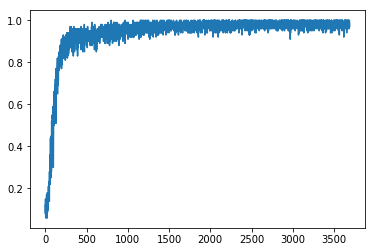

In [38]:
plt.plot(mem.classif_eval)

In [39]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_data(x_test)
classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                        x_4: wave_tensor[4],\
                                        x_3: wave_tensor[3],\
                                        x_2: wave_tensor[2],\
                                        x_1: wave_tensor[1],\
                                        x_0: wave_tensor[0],\
                                        y: y_test,\
                                        keep_prob: 1,\
                                        batch_phase:False})
sys.stdout.write('\rstep %d\t classif : %.5f' \
                 % (num_epoch, \
                    classif_eval))

step 0	 classif : 0.98180